In [142]:
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt
%matplotlib inline

In [143]:
@u.quantity_input
def differential_flux(energy: u.TeV, norm: 1/(u.TeV * u.s * u.m**2), index):
    return norm * energy.to_value(u.TeV) ** index

In [144]:
@u.quantity_input
def integrate(e_min: u.TeV, e_max: u.TeV, norm: 1/(u.TeV * u.s * u.m**2), index):
    a = e_min.to_value('TeV')
    b = e_max.to_value('TeV')
    norm_ = norm.to(1 / (u.TeV * u.s * u.m**2)) * u.TeV
    return norm_ * (1 / (index + 1)) * (b**(index + 1) - a**(index + 1))

In [145]:
@u.quantity_input
def observation_time(e_min: u.TeV, e_max: u.TeV, area:u.m**2, norm: 1/(u.TeV * u.s * u.m**2), index, n_events):
    return (n_events / (integrate(e_min, e_max, norm, index) * area)).to(u.s)

In [146]:
@u.quantity_input
def expected_events(e_min: u.TeV, e_max: u.TeV, area:u.m**2, norm: 1/(u.TeV * u.s * u.m**2), index, t_obs: u.s):
    return (integrate(e_min, e_max, norm, index) * area * t_obs).si.value

In [147]:
@u.quantity_input
def expected_events_for_bins(energy_bins: u.TeV, area:u.m**2, norm: 1/(u.TeV * u.s * u.m**2), index, t_obs: u.s):
    return np.array([expected_events(l, h, area, norm, index, t_obs) for (l, h) in zip(energy_bins[0:], energy_bins[1:])])

In [148]:
@u.quantity_input
def sample(e_min: u.TeV, e_max: u.TeV, index, size):
    a = e_min.to_value('TeV') ** (index + 1)
    b = e_max.to_value('TeV') ** (index + 1)
    r = np.random.uniform(0, 1, size)
    k = (a + (b - a) * r)
    e = k ** (1. / (index + 1))
    return u.Quantity(e, u.TeV, copy=False)

In [149]:
@u.quantity_input
def make_energy_bins(e_min: u.TeV, e_max: u.TeV, bins=10):
    unit = e_min.unit
    low = np.log10(e_min.value)
    high = np.log10(e_max.value)
    bin_edges = np.logspace(low, high, endpoint=True, num=bins + 1) * unit
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)
    return bin_edges, bin_centers, bin_widths

In [150]:
energy_bins, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=20)

In [151]:
# Define Crab spectra
crab_norm = u.Quantity(2.83e-14, 1/(u.GeV * u.cm**2 * u.s), copy=False)
crab_index = -2.62

In [152]:
area = 1 * u.km**2
crab_e_min = 0.003 * u.TeV
crab_e_max = 300 * u.TeV



crab_energy_bins, crab_bin_center, crab_bin_width = make_energy_bins(e_min=crab_e_min, e_max=crab_e_max, bins=20)

In [153]:
# Obtain rate of events from crab
crab_rate = expected_events_for_bins(crab_energy_bins, area, crab_norm, crab_index, 1 * u.s)
print(f"Total Crab rate: {crab_rate.sum():.2f} events/sec")

Total Crab rate: 2134.69 events/sec


In [154]:
# Define first simulation spectrum
mc1_index = -2
n_mc1_events = 100000
mc1_e_min = 0.003 * u.TeV
mc1_e_max = 10 * u.TeV
# Set MC spectrum normalisation such that it gives us the correct number of events
N = integrate(mc1_e_min, mc1_e_max, 1/(u.TeV * u.s * u.m**2), mc1_index) * area * 1*u.s
mc1_norm = (n_mc1_events / N).si.value / (u.TeV * u.m**2 * u.s)

# Now lets run our simulation
mc1_events = sample(mc1_e_min, mc1_e_max, mc1_index, n_mc1_events)

In [155]:
# Define second simulation spectrum
mc2_index = -1.4
n_mc2_events = 500000
mc2_e_min = 0.1 * u.TeV
mc2_e_max = 300 * u.TeV
# Set MC spectrum normalisation such that it gives us the correct number of events
N = integrate(mc2_e_min, mc2_e_max, 1/(u.TeV * u.s * u.m**2), mc2_index) * area * 1*u.s
mc2_norm = (n_mc2_events / N).si.value / (u.TeV * u.m**2 * u.s)

# Now lets run our simulation
mc2_events = sample(mc2_e_min, mc2_e_max, mc2_index, n_mc2_events)

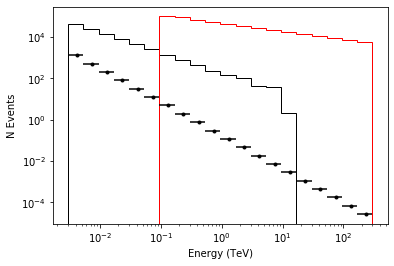

In [156]:
plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab in 1 sec', color='black',
)
plt.hist(mc1_events.value, crab_energy_bins, histtype='step', color='black')
plt.hist(mc2_events.value, crab_energy_bins, histtype='step', color='red')
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

In [157]:
@u.quantity_input
def calculate_weights(energies: u.TeV, index, mc_index):
    return energies.to_value(u.TeV) ** (index - mc_index)

@u.quantity_input
def calculate_t_norm(e_min: u.TeV, e_max: u.TeV, area: u.m**2, mc_index, norm, n_simulated):
    a = e_min.to_value('TeV')
    b = e_max.to_value('TeV')
    norm_ = norm.to(1 / (u.TeV * u.s * u.m**2)) * u.TeV
    integral = norm_ * (b**(mc_index + 1) - a**(mc_index + 1)) / (mc_index + 1)
    t_norm = (n_simulated / (integral * area)).to_value(u.s)
    return t_norm

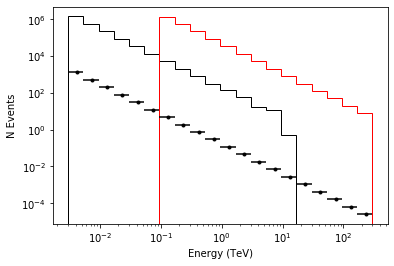

In [158]:
# Check just the shape

mc1_weights = calculate_weights(mc1_events, crab_index, mc1_index)
mc2_weights = calculate_weights(mc2_events, crab_index, mc2_index)

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab in 1 sec', color='black',
)
plt.hist(mc1_events.value, crab_energy_bins, weights=mc1_weights, histtype='step', color='black')
plt.hist(mc2_events.value, crab_energy_bins, weights=mc2_weights, histtype='step', color='red')
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

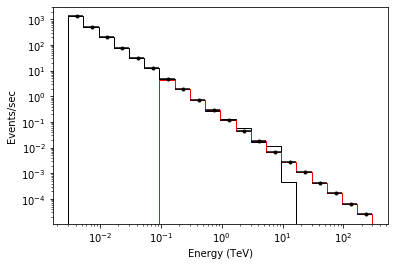

In [159]:
# Also check normalisation

mc1_t_norm = calculate_t_norm(mc1_e_min, mc1_e_max, area, mc1_index, crab_norm, n_mc1_events)
mc2_t_norm = calculate_t_norm(mc2_e_min, mc2_e_max, area, mc2_index, crab_norm, n_mc2_events)

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='crab rate', color='black',
)
plt.hist(mc1_events.value, crab_energy_bins, weights=mc1_weights/mc1_t_norm, histtype='step', color='black')
plt.hist(mc2_events.value, crab_energy_bins, weights=mc2_weights/mc2_t_norm, histtype='step', color='red')
plt.xlabel("Energy (TeV)")
plt.ylabel("Events/sec")
plt.xscale('log')
plt.yscale('log')

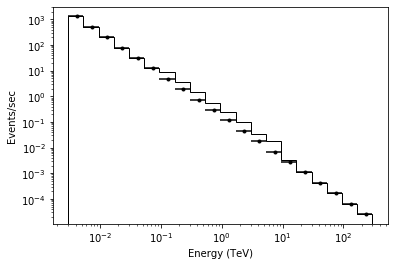

In [160]:
# Problem: Combined population

mcc_events = np.concatenate([mc1_events, mc2_events])
mcc_weights = np.concatenate([mc1_weights/mc1_t_norm, mc2_weights/mc2_t_norm])

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='crab rate', color='black',
)
plt.hist(mcc_events.value, crab_energy_bins, weights=mcc_weights, histtype='step', color='black')
plt.xlabel("Energy (TeV)")
plt.ylabel("Events/sec")
plt.xscale('log')
plt.yscale('log')

#!!!!! Results in extra values in overlap!

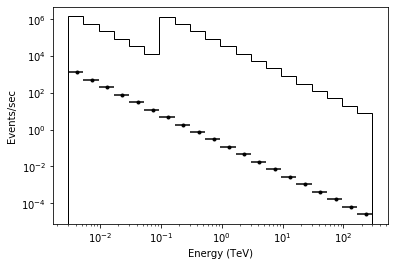

In [161]:
mcc_events = np.concatenate([mc1_events, mc2_events])
mcc_weights = np.concatenate([mc1_weights, mc2_weights])

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='crab rate', color='black',
)
plt.hist(mcc_events.value, crab_energy_bins, weights=mcc_weights, histtype='step', color='black')
plt.xlabel("Energy (TeV)")
plt.ylabel("Events/sec")
plt.xscale('log')
plt.yscale('log')

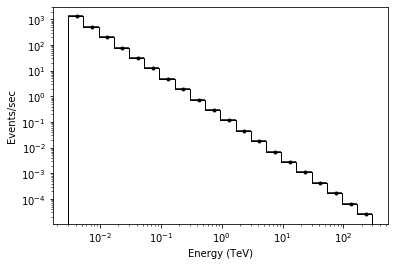

In [162]:
mcc_events = np.concatenate([mc1_events, mc2_events])
mcc_weights = np.concatenate([mc1_weights, mc2_weights])
mcc_weights_wtn = np.concatenate([mc1_weights/mc1_t_norm, mc2_weights/mc2_t_norm])
overlap_events = (mcc_events >= mc2_e_min.value) & (mcc_events < mc1_e_max.value)
mcc_weights_wtn[overlap_events] = mcc_weights[overlap_events] / (mc1_t_norm + mc2_t_norm)

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='crab rate', color='black',
)
plt.hist(mcc_events.value, crab_energy_bins, weights=mcc_weights_wtn, histtype='step', color='black')
plt.xlabel("Energy (TeV)")
plt.ylabel("Events/sec")
plt.xscale('log')
plt.yscale('log')

# So the solution is that the overlapping bins need to be normalized by the comined time...makes sense

1060.3887880144964 293271.8200094085 294332.208797423


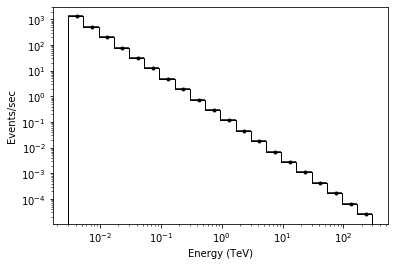

In [163]:
# Need to find a generic way to calculate this...
# A bin specific weighting

mcc_events = np.concatenate([mc1_events, mc2_events])
mcc_weights = np.concatenate([mc1_weights, mc2_weights])

t_norm_arr = np.zeros(mcc_events.size)
t_norm_arr[(mcc_events >= mc1_e_min.value) & (mcc_events < mc1_e_max.value)] += mc1_t_norm
t_norm_arr[(mcc_events >= mc2_e_min.value) & (mcc_events < mc2_e_max.value)] += mc2_t_norm

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='crab rate', color='black',
)
plt.hist(mcc_events.value, crab_energy_bins, weights=mcc_weights/t_norm_arr, histtype='step', color='black')
plt.xlabel("Energy (TeV)")
plt.ylabel("Events/sec")
plt.xscale('log')
plt.yscale('log')


print(mc1_t_norm, mc2_t_norm, mc1_t_norm+mc2_t_norm)

# GOT IT

### Lets apply this to N sims

In [169]:
import pandas as pd

n_sim = 6
e_min = np.exp(np.random.uniform(np.log(0.001), np.log(100), n_sim)) * u.TeV
e_max = np.exp(np.random.uniform(np.log(e_min.value), np.log(300), n_sim)) * u.TeV
mc_index = np.random.uniform(-3, -1, n_sim)
n_simulated = np.random.uniform(100000, 1000000, n_sim).astype(np.int)

N = integrate(e_min, e_max, 1/(u.TeV * u.s * u.m**2), mc_index) * area * 1*u.s
mc_norm = (n_simulated / N).si.value / (u.TeV * u.m**2 * u.s)

# Now lets run our simulation
d_list = []
mc_events = []
for isim in range(n_sim):
    events = sample(e_min[isim], e_max[isim], mc_index[isim], n_simulated[isim])
    d_list.append(dict(
        isim=isim,
        e_min=e_min[isim].value,
        e_max=e_max[isim].value,
        index=mc_index[isim],
        n_simulated=n_simulated[isim],
        events=events.value,
        weights=calculate_weights(events, crab_index, mc_index[isim]),
    ))
df = pd.DataFrame(d_list)


calculate_t_norm(mc1_e_min, mc1_e_max, area, mc1_index, crab_norm, n_mc1_events)
df['t_norm'] = calculate_t_norm(df['e_min'].values*u.TeV, df['e_max'].values*u.TeV, area, df['index'].values, crab_norm, df['n_simulated'].values)


In [170]:
df

,isim,e_min,e_max,index,n_simulated,events,weights,t_norm
0,0,0.317217,1.443215,-2.089247,580103,"[0.7126531575279814, 0.46611241400400716, 0.75...","[1.1969757902632412, 1.4995109974187704, 1.164...",7.912032e+05
1,1,2.243292,50.455178,-2.348221,792688,"[2.414415239299131, 7.093102980143129, 4.95434...","[0.7869725357419637, 0.5871650413561287, 0.647...",1.139537e+07
2,2,0.008293,5.878664,-1.501184,496552,"[0.027917734750704703, 0.0159127564447713, 0.0...","[54.7992855008672, 102.78195970715693, 129.473...",8.271283e+04
3,3,0.011308,0.125029,-2.809025,236558,"[0.012403433464340597, 0.012625376331236454, 0...","[0.43614672131801163, 0.4376113292528699, 0.44...",4.611126e+02
4,4,4.321380,22.695748,-1.572443,907408,"[8.924083228404308, 9.124939396320764, 14.5878...","[0.10097891863678278, 0.09865171459510542, 0.0...",6.920087e+06
5,5,0.105142,0.933954,-1.590516,862504,"[0.41826793866107265, 0.1765825323760496, 0.77...","[2.453049687958151, 5.960120347229084, 1.29813...",6.567729e+05


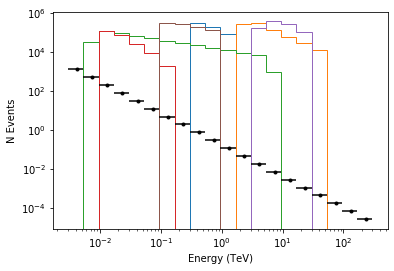

In [171]:
# Without norm

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab in 1 sec', color='black',
)

for _, row in df.iterrows():
    plt.hist(row['events'], crab_energy_bins, histtype='step')
    
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

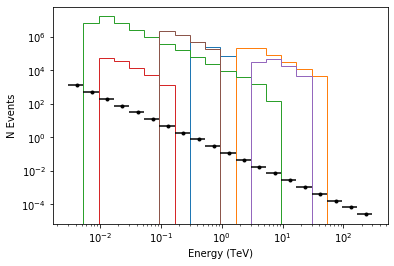

In [172]:
# With just index corrected

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab in 1 sec', color='black',
)

for _, row in df.iterrows():
    plt.hist(row['events'], crab_energy_bins, weights=row['weights'], histtype='step')
    
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

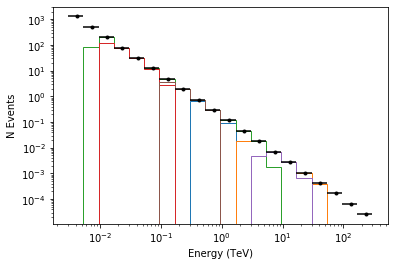

In [175]:
# Corrected

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab in 1 sec', color='black',
)

for _, row in df.iterrows():
    energies = row['events']
    plt.hist(row['events'], crab_energy_bins, weights=row['weights']/row['t_norm'], histtype='step')
    
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')

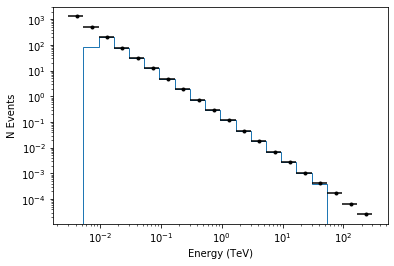

In [176]:
# Combined

plt.errorbar(
    crab_bin_center.value, crab_rate, xerr=crab_bin_width.value * 0.5,
    linestyle='', marker='.', label='expected events from crab in 1 sec', color='black',
)

energies_list = []
weights_list = []

for _, row in df.iterrows():
    energies = row['events']
    t_norm_total = np.zeros(energies.size)
    for ic, row_c in df.iterrows():
        between = (energies >= row_c['e_min']) & (energies < row_c['e_max'])
        t_norm_total[between] += row_c['t_norm']
    energies_list.append(energies)
    weights_list.append(row['weights']/t_norm_total)

energies = np.concatenate(energies_list)
weights = np.concatenate(weights_list)
    
plt.hist(energies, crab_energy_bins, weights=weights, histtype='step')
    
plt.xlabel("Energy (TeV)")
plt.ylabel("N Events")
plt.xscale('log')
plt.yscale('log')